In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import keras
import numpy as np

Using TensorFlow backend.


In [3]:
np.random.normal(loc=[0.0,1.0], scale=[1.0,2.0], size = [5,2])

array([[-0.72837402, -2.79299399],
       [-0.44302593,  0.2220522 ],
       [ 0.59762634, -0.73202762],
       [-1.62164864,  2.11639857],
       [-1.86748828, -0.78333612]])

In [4]:
from tensorflow.contrib.distributions import MultivariateNormalDiag
import tensorflow as tf
sess = tf.Session()

In [5]:
a = md.sample(5)
sess.run(a)

NameError: name 'md' is not defined

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

In [7]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='alexander-prutko', api_key='VocBkhjfvvSy6zHJ8789')

ModuleNotFoundError: No module named 'plotly'

In [8]:
from scipy.stats import multivariate_normal

In [243]:
# параметры распределений
mu0X, mu0Y, sigma0 = -1., -1., 1.
mu1X, mu1Y, sigma1 = 1., 1., 2.

In [244]:
# def sample(d0, d1, n=32):
#     x0 = d0.sample((n,))
#     x1 = d1.sample((n,))
#     y0 = torch.zeros((n, 1))
#     y1 = torch.ones((n, 1))
#     return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

# def sample(d0, d1, n=32):
#     x0 = d0.sample((n,))
#     x1 = d1.sample((n,))
#     y0 = tf.zeros((n, 1))
#     y1 = tf.ones((n, 1))
#     return tf.concat([x0, x1], 0), tf.concat([y0, y1], 0)   

def sample(d0, d1, n=32):
    x0 = d0(n)
    x1 = d1(n)
    y0 = np.zeros((n, 1))
    y1 = np.ones((n, 1))
    return np.vstack([x0, x1]), np.vstack([y0, y1])   

In [245]:
#d0 = torch.distributions.Normal(torch.tensor([mu0X, mu0Y]), torch.tensor([sigma0]))
#d1 = torch.distributions.Normal(torch.tensor([mu1X, mu1Y]), torch.tensor([sigma1]))

# d0 = MultivariateNormalDiag(loc=[mu0X, mu0Y], scale_diag=[sigma0, sigma0])
# d1 = MultivariateNormalDiag(loc=[mu1X, mu1Y], scale_diag=[sigma1, sigma1])

d0 = lambda n : np.random.normal(loc=[mu0X, mu0Y], scale=[sigma0, sigma0], size = [n,2])
d1 = lambda n : np.random.normal(loc=[mu1X, mu1Y], scale=[sigma1, sigma1], size = [n,2])

In [246]:
# aa = sample(d0, d1, 3)
# sess.run(aa)

sample(d0, d1, 3)

(array([[-0.91410349, -1.00053263],
        [-1.14951076, -2.25013685],
        [-0.21308673, -3.30991215],
        [-3.77757514, -1.49335028],
        [ 0.7545366 ,  0.9492806 ],
        [-3.02619217,  2.52570322]]), array([[ 0.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.]]))

In [247]:
nx, ny = (300, 300)
x_ = np.linspace(-10, 10, nx)
y_ = np.linspace(-10, 10, ny)
xv, yv = np.meshgrid(x_, y_)
F0 = multivariate_normal([mu0X, mu0Y], sigma0)
F1 = multivariate_normal([mu1X, mu1Y], sigma1)

grid_list = list(zip(xv.reshape(1,-1).tolist()[0], yv.reshape(1,-1).tolist()[0]))
grid = np.reshape(grid_list, (nx,ny,2))
f0 = F0.pdf(grid)
f1 = F1.pdf(grid)
ratio = f1 / (f1 + f0)

In [262]:
# net = nn.Sequential(nn.Linear(2, 10), nn.SELU(), nn.Linear(10, 10), nn.SELU(), nn.Linear(10, 1))
# net_opt = optim.SGD(lr=1e-3, params=list(net.parameters()))
learning_rate = 0.01
initializer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y = tf.placeholder(shape=[None, 1], dtype=tf.float32)
# nn = tf.layers.dense(x, 10, activation=tf.nn.relu, kernel_initializer=initializer)
# nn = tf.layers.dense(nn, 10, activation=tf.nn.relu, kernel_initializer=initializer)
encoded = tf.layers.dense(x, 1, activation=None, kernel_initializer=initializer)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=encoded)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

predicted = tf.nn.sigmoid(encoded)
correct_pred = tf.equal(tf.round(predicted), y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

In [263]:
with tf.Session() as sess:
    sess.run(init)
    for step in range(10000):
        a = sample(d0, d1, 100)
        loss, _, acc = sess.run([cost, optimizer, accuracy],
                                   feed_dict={x: a[0], y: a[1]})
        if step % 1000 == 0:
            b = sample(d0, d1, 10000)
            loss, acc = sess.run([cost, accuracy],
                                   feed_dict={x: b[0], y: b[1]})
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))
            
    pred = sess.run([predicted], feed_dict={x: grid.reshape(-1,2)})

Step:     0	Loss: 1.529	Acc: 32.64%
Step:  1000	Loss: 0.394	Acc: 83.65%
Step:  2000	Loss: 0.395	Acc: 83.93%
Step:  3000	Loss: 0.394	Acc: 83.93%
Step:  4000	Loss: 0.392	Acc: 83.86%
Step:  5000	Loss: 0.398	Acc: 83.45%
Step:  6000	Loss: 0.399	Acc: 83.58%
Step:  7000	Loss: 0.394	Acc: 83.93%
Step:  8000	Loss: 0.393	Acc: 83.64%
Step:  9000	Loss: 0.390	Acc: 83.96%


In [264]:
# N = 10000
# a = sample(d0, d1, N)
# with tf.Session() as sess:
#     sess.run(init)
#     pred, acc = sess.run([correct_pred, accuracy], feed_dict={x: a[0], y: a[1]})
# # np.sum(np.abs(np.round(pred).flatten() - a[1].flatten()))/2/N
# np.sum(pred)/2.0/N, acc

In [265]:
# nx, ny = (300, 300)
# x_ = np.linspace(-10, 10, nx)
# y = np.linspace(-10, 10, ny)
# xv, yv = np.meshgrid(x_, y)
# F0 = multivariate_normal([mu0X, mu0Y], sigma0)
# F1 = multivariate_normal([mu1X, mu1Y], sigma1)

# grid_list = list(zip(xv.reshape(1,-1).tolist()[0], yv.reshape(1,-1).tolist()[0]))
# grid = np.reshape(grid_list, (nx,ny,2))
# f0 = F0.pdf(grid)
# f1 = F1.pdf(grid)
# ratio = f1 / (f1 + f0)
# #tensor_grid = torch.tensor(grid, dtype=torch.float)
# #with torch.no_grad():
# #    dist = F.sigmoid(net(tensor_grid.cuda())).cpu().numpy()

# with tf.Session() as sess:
#     sess.run(init)
#     pred = sess.run([predicted], feed_dict={x: grid.reshape(-1,2)})
# # # np.round(pred).flatten(), a[1].flatten()    

In [266]:
dist = pred[0].reshape(nx, ny)

In [267]:
ratio

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  0.99999999, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  0.99999999,  0.99999999, ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [268]:
grid.reshape(-1,2).shape
type(grid.reshape(-1,2))
type(a[0])

numpy.ndarray

In [269]:
ratio.shape

(300, 300)

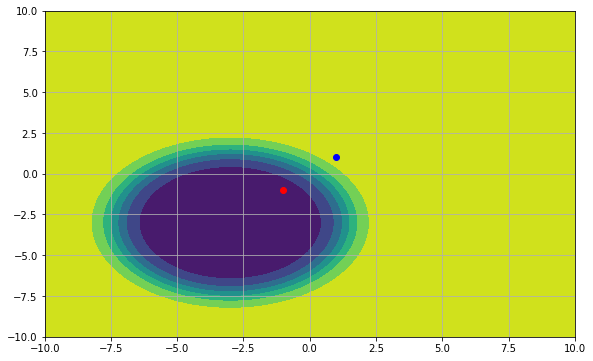

In [270]:
plt.contourf(x_,y_,ratio)
plt.scatter([-1],[-1], c='red')
plt.scatter([1],[1], c='blue')
plt.grid(True)

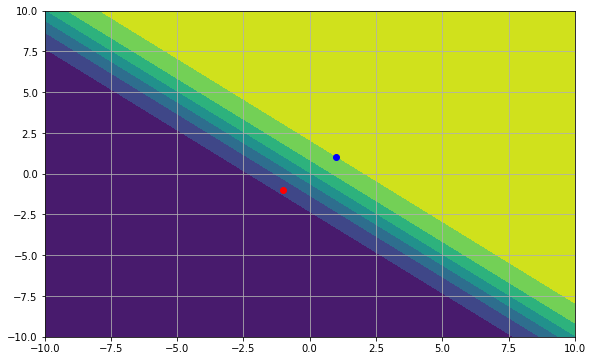

In [271]:
dist = dist.reshape((nx,ny))
h = plt.contourf(x_,y_,dist)
plt.scatter([-1],[-1], c='red')
plt.scatter([1],[1], c='blue')
plt.grid(True)

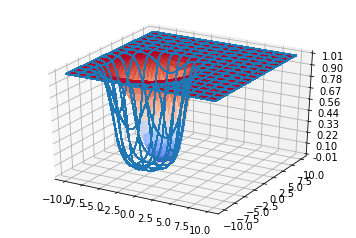

In [258]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(xv, yv, dist, cmap=cm.coolwarm, rstride=5, cstride=5,
                       linewidth=0, antialiased=False)
surf = ax.plot_wireframe(xv, yv, ratio, cmap=cm.coolwarm, rstride=20, cstride=20,
                       linewidth=1, antialiased=False)


ax.set_zlim(-0.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

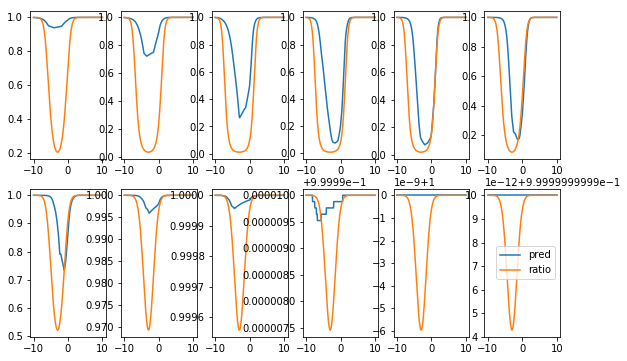

In [260]:
plt.rcParams['figure.figsize'] = [9.5, 6]
yy = 50
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.plot(x_, dist[yy+20*i,:], label='pred')
    plt.plot(x_, ratio[yy+20*i,:], label='ratio')
plt.legend();

In [261]:
data = [go.Surface(z=dist, x=xv, y=yv, opacity=1.00, colorscale='Greens'),
        go.Surface(z=ratio, x=xv, y=yv, opacity=0.8)]

NameError: name 'go' is not defined

In [18]:
py.iplot(data,filename='plot')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~alexander-prutko/0 or inside your plot.ly account where it is named 'plot'


[plotly plot](https://plot.ly/~alexander-prutko/0)